# Convolutional Neural Network (CNN)

Deep Learning-based methods for individual recognition of *Calotriton Asper*,
Master's Thesis

Lola Pailler García 1430776

In [ ]:
BASE_FOLDER = '/content/drive/My Drive/'
from google.colab import drive
drive.mount('/content/drive/', force_remount = True)

Mounted at /content/drive/


In [ ]:
from numpy import array, zeros
from os.path import join
from skimage.color import gray2rgb
from skimage.io import imread
from skimage.transform import resize
import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
from skimage.io import imshow
import imutils
import keras
import tensorflow as tf
import tensorflow_datasets as tfds

We read the correspondences file

In [ ]:
dft = pd.read_excel(BASE_FOLDER + 'TritonesCorrespondencias.xlsx', sheet_name="Todas")
display(dft)
dft.Triton.value_counts()

,Triton,Image,Location,Month,Year,Orientation
0,T0001,IMG_1833_2020,Mascarida,August,2020,U
1,T0001,IMG_1834_2020,Mascarida,August,2020,U
2,T0001,IMG_1835_2020,Mascarida,August,2020,U
3,T0002,IMG_1836_2020,Mascarida,August,2020,U
4,T0002,IMG_1837_2020,Mascarida,August,2020,U
...,...,...,...,...,...,...
1557,L0016,IMG_1571_2021,Torrent de la Muga,July,2021,U
1558,L0016,IMG_1572_2021,Torrent de la Muga,July,2021,U
1559,L0016,IMG_1573_2021,Torrent de la Muga,July,2021,U
1560,L0016,IMG_1574_2021,Torrent de la Muga,July,2021,U


L0016    16
F0003    13
K0019    12
K0002    12
L0002    11
         ..
T0051     2
A0004     2
T0065     2
E0026     2
E0025     2
Name: Triton, Length: 311, dtype: int64

We read the cut images

In [ ]:
direct = BASE_FOLDER + 'Bellies_error'

imgs, names = [], []
for item in os.listdir(direct):
  img = cv2.imread(os.path.join(direct, item))
  imgs.append(img)
  names.append(item)

In [ ]:
names = [sub.replace('.jpg', '') for sub in names]

# create dictionary
dictionary = {}
for i, im in enumerate(imgs):
  dictionary[names[i]] = im

# Create dictionary of dictionaries
dictionary_names = (dft.groupby('Triton')
       .apply(lambda x: dict(x['Image']))
       .to_dict())

In [ ]:
tritones, ims = [], []
for i, name in enumerate(names):
  for triton, images in dictionary_names.items():
    for key in images:
      if images[key] == name:
          tritones.append(triton)
          ims.append(imgs[i])

We define X as the images and Y as the individual labels

In [ ]:
Y = tritones
X1 = np.stack(ims, axis=0)

Shuffle randomly and save one image of each individual for the testing set

In [ ]:
indx_shuffle = np.arange(len(Y))
np.random.shuffle(indx_shuffle)
Y_shuffle = np.array(Y)[indx_shuffle]
X_shuffle = X1[indx_shuffle]

In [ ]:
unique_element, unique_indx = np.unique(Y_shuffle, return_index = True)
mask_indx = np.isin(np.arange(len(X_shuffle)), unique_indx)

In [ ]:
import random
mask_indx[random.randint(sum(mask_indx), len(mask_indx)-1)] = True

In [ ]:
X_test = X_shuffle[mask_indx]
Y_test = Y_shuffle[mask_indx]

X_tv = X_shuffle[~mask_indx]
Y_tv = Y_shuffle[~mask_indx]

We check the numer of images and labels for testing

In [ ]:
len(np.unique(Y_test)), len(Y_test)

(311, 312)

In [ ]:
len(np.unique(Y_tv)), len(Y_tv)

(311, 1248)

Now not all the individuals had two images. In order to be able to split into validation and training we check which individuals had only one image and duplicate this ones with an augmentation method (randoom rotation)

In [ ]:
unique_tv_labs, unique_tv_indx, unique_tv_count = np.unique(Y_tv, return_index=True, return_counts=True)
indx_with_one, lab_with_one = unique_tv_indx[unique_tv_count == 1], unique_tv_labs[unique_tv_count == 1]

In [ ]:
X_tv_one_dup = [tf.image.flip_left_right(x) for x in X_tv[indx_with_one]]

In [ ]:
X_tv = np.concatenate((X_tv, X_tv_one_dup))
Y_tv = np.concatenate((Y_tv, lab_with_one))

In [ ]:
len(np.unique(Y_tv)), len(Y_tv)

(311, 1258)

Now that all the individuals had minimum two images, we randomly split again into training and validation

In [ ]:
indx_shuffle = np.arange(len(Y_tv))
np.random.shuffle(indx_shuffle)
Y_tv = np.array(Y_tv)[indx_shuffle]
X_tv = X_tv[indx_shuffle]

In [ ]:
unique_element_tv, unique_indx_tv = np.unique(Y_tv, return_index = True)
mask_indx_tv = np.isin(np.arange(len(X_tv)), unique_indx_tv)

In [ ]:
mask_indx_tv[random.randint(sum(mask_indx_tv), len(mask_indx_tv)-1)] = True

In [ ]:
X_val = X_tv[mask_indx_tv]
Y_val = Y_tv[mask_indx_tv]

X_train = X_tv[~mask_indx_tv]
Y_train = Y_tv[~mask_indx_tv]

We check the validation and training set sizes

In [ ]:
len(np.unique(Y_val)), len(Y_val)

(311, 312)

In [ ]:
len(np.unique(Y_train)), len(Y_train)

(311, 946)

Now we have split data into training, validation and testing we perform data augmentation in training set.

In [ ]:
X_train_flipped = [tf.image.flip_left_right(x) for x in X_train]
X_train_zoom = [tf.keras.preprocessing.image.random_zoom(x, (60, 200)) for x in X_train]

In [ ]:
YYY_train = np.concatenate((Y_train, Y_train, Y_train))
XXX_train = np.concatenate((X_train, X_train_flipped, X_train_zoom))

indx_train = np.arange(len(YYY_train))
np.random.shuffle(indx_train)
YYY_train = [YYY_train[i] for i in indx_train]
XXX_train = XXX_train[indx_train]

In [ ]:
XXX_train = np.stack(XXX_train, axis=0)
X_val = np.stack(X_val, axis=0)
X_test = np.stack(X_test, axis=0)

YYY_train = np.array(YYY_train)
Y_val = np.array(Y_val)
Y_test = np.array(Y_test)

YYY_train = YYY_train.reshape((len(YYY_train), 1))
Y_val = Y_val.reshape((len(Y_val), 1))
Y_test = Y_test.reshape((len(Y_test), 1))

Once the sets were prepared we one-hot them

In [ ]:
from sklearn.preprocessing import LabelBinarizer

encoder = LabelBinarizer()
YYY_train_enc = encoder.fit_transform(YYY_train)

Y_val_enc = encoder.fit_transform(Y_val)

Y_test_enc = encoder.fit_transform(Y_test)


YYY_train_enc = np.array(YYY_train_enc)
Y_val_enc = np.array(Y_val_enc)
Y_test_enc = np.array(Y_test_enc)

In [ ]:
YYY_train_position = np.argmax(YYY_train_enc, axis=1)
dictionary_position = dict(zip(YYY_train_position, YYY_train))

In [ ]:
"""
from keras.models import Sequential
from keras.layers import (
    Conv2D, MaxPooling2D, Flatten,
    Dense, Dropout, Activation, BatchNormalization
)
from keras import regularizers, optimizers, metrics
# from keras.optimizers import Adam

model = Sequential()
# data_augmentation,
model.add(Conv2D(32, (3, 3),
                 activation='relu',
                 padding='same',
                 input_shape=(200, 60, 3))) # !!!!
# model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(311, activation='softmax')) # Number of final clases!

model.compile(optimizers.RMSprop(learning_rate=0.001),
              loss="categorical_crossentropy",
              metrics=["accuracy", keras.metrics.Precision(), keras.metrics.Recall()])
"""

In [ ]:
"""
from keras.models import Sequential
from keras.layers import (
    Conv2D, MaxPooling2D, GlobalMaxPooling2D, Flatten,
    Dense, Dropout, Activation, BatchNormalization, LeakyReLU
)
from keras import regularizers, optimizers, metrics
# from keras.optimizers import Adam

self_cnn = Sequential()
# data_augmentation,
self_cnn.add(Conv2D(32, (3, 3),
                 padding='same',
                 input_shape=(200, 60, 3))) # !!!!
self_cnn.add(LeakyReLU(0.02))
# model.add(Conv2D(64, (3, 3), activation='relu'))
self_cnn.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))

self_cnn.add(Conv2D(64, (3, 3), padding='same'))
self_cnn.add(LeakyReLU(0.02))
# model.add(Conv2D(64, (3, 3), activation='relu'))
self_cnn.add(GlobalMaxPooling2D())
self_cnn.add(Dropout(0.25))

self_cnn.add(Flatten())
self_cnn.add(Dense(512))
self_cnn.add(Activation('relu'))
self_cnn.add(Dropout(0.5))
self_cnn.add(Dense(311, activation='softmax')) # Number of final clases!

self_cnn.compile(optimizers.RMSprop(learning_rate=0.001),
              loss="categorical_crossentropy",
              metrics=["accuracy", keras.metrics.Precision(), keras.metrics.Recall()])
"""

### We prepared the structure of the CNN

In [ ]:
from keras.models import Sequential
from keras.layers import (
    Conv2D, MaxPooling2D, Flatten,
    Dense, Dropout, Activation, BatchNormalization
)
from keras import regularizers, optimizers, metrics
from keras.optimizers import Adam

self_cnn = Sequential()
# data_augmentation,
self_cnn.add(Conv2D(32, (3, 3),
                 activation='relu',
                 padding='same',
                 input_shape=(200, 60, 3)))
self_cnn.add(Conv2D(64, (3, 3), activation='relu'))
self_cnn.add(MaxPooling2D(pool_size=(2, 2)))
self_cnn.add(Dropout(0.25))

self_cnn.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
self_cnn.add(Conv2D(64, (3, 3), activation='relu'))
self_cnn.add(MaxPooling2D(pool_size=(2, 2)))
self_cnn.add(Dropout(0.25))

self_cnn.add(Flatten())
self_cnn.add(Dense(512))
self_cnn.add(Activation('relu'))
self_cnn.add(Dropout(0.5))
self_cnn.add(Dense(311, activation='softmax')) # Number of final clases!

In [ ]:
self_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 200, 60, 32)       896       
                                                                 
 conv2d_5 (Conv2D)           (None, 198, 58, 64)       18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 99, 29, 64)        0         
 g2D)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 99, 29, 64)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 99, 29, 64)        36928     
                                                                 
 conv2d_7 (Conv2D)           (None, 97, 27, 64)        36928     
                                                      

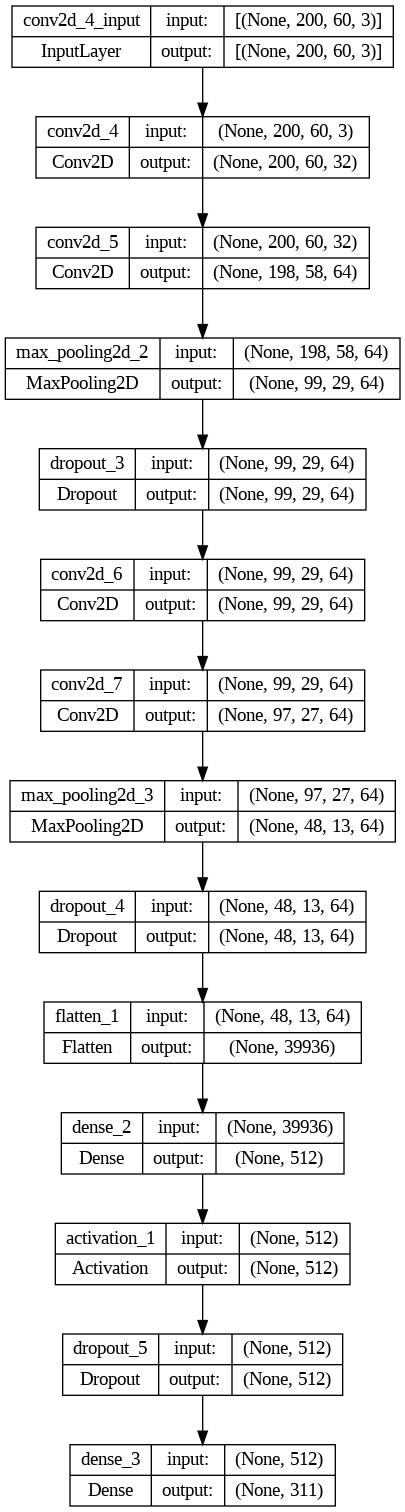

In [ ]:
from keras.utils import plot_model
plot_model(self_cnn, to_file='CNNmodelDataAugmentation_X.png', show_shapes=True)

Function to plot the evaluation metrics

In [ ]:
def metrics_plot(mod_cnn):
  fig, axs = plt.subplots(2, 2)
  # Accurary
  axs[0, 0].plot(mod_cnn.history['accuracy'])
  axs[0, 0].plot(mod_cnn.history['val_accuracy'])
  axs[0, 0].set(ylabel='Accuracy')
  # axs[0, 0].xlabel('epoch')

  # Loss
  axs[0, 1].plot(mod_cnn.history['loss'])
  axs[0, 1].plot(mod_cnn.history['val_loss'])
  axs[0, 1].set(ylabel='Loss')
  # axs[0, 1].xlabel('epoch')

  # Precission
  axs[1, 0].plot(mod_cnn.history['precision_1'])
  axs[1, 0].plot(mod_cnn.history['val_precision_1'])
  axs[1, 0].set(ylabel='Precision')
  # axs[1, 0].xlabel('epoch')

  # Recall
  axs[1, 1].plot(mod_cnn.history['recall_1'])
  axs[1, 1].plot(mod_cnn.history['val_recall_1'])
  axs[1, 1].set(ylabel='Recall')
  # axs[1, 1].xlabel('epoch')

  plt.figlegend(['Train', 'Validation'], loc='lower center', ncol=2)
  plt.show()

We compile the model

In [ ]:
self_cnn.compile(optimizers.RMSprop(learning_rate=0.001),
             loss="categorical_crossentropy",
             metrics=["accuracy", keras.metrics.Precision(), keras.metrics.Recall()])

Important, transform the images

In [ ]:
XXX_train = XXX_train/256.0
X_val = X_val/256.0
X_test = X_test/256.0

We fit the model with 32 batch size and 30 epochs

In [ ]:
self_cnn_30epochs = self_cnn.fit(XXX_train, YYY_train_enc,
          # steps_per_epoch=64,
          batch_size = 32,
          validation_data = (X_val, Y_val_enc),
          epochs=30)

Epoch 1/30
89/89 [==============================] - 267s 3s/step - loss: 5.8126 - accuracy: 0.0085 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - val_loss: 5.7971 - val_accuracy: 0.0064 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 2/30
89/89 [==============================] - 274s 3s/step - loss: 5.5564 - accuracy: 0.0162 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - val_loss: 5.7326 - val_accuracy: 0.0064 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 3/30
89/89 [==============================] - 279s 3s/step - loss: 5.3844 - accuracy: 0.0314 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - val_loss: 5.5982 - val_accuracy: 0.0321 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 4/30
89/89 [==============================] - 280s 3s/step - loss: 4.9830 - accuracy: 0.0553 - precision_1: 0.2222 - recall_1: 7.0472e-04 - val_loss: 5.4414 - val_accuracy: 0.0256 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 5/30
89/89

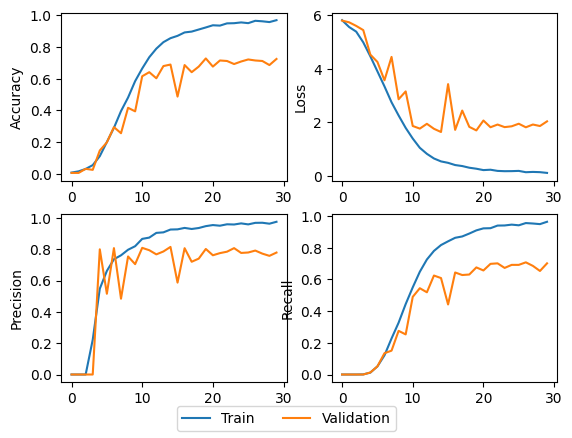

In [ ]:
metrics_plot(self_cnn_30epochs)

Model evaluation and prediction

In [ ]:
res_cnn = self_cnn.evaluate(X_test, Y_test_enc)
print("Test loss and test accuracy:", res_cnn)

10/10 [==============================] - 7s 666ms/step - loss: 2.3594 - accuracy: 0.6891 - precision_1: 0.7527 - recall_1: 0.6731
Test loss and test accuracy: [2.359415292739868, 0.6891025900840759, 0.7526881694793701, 0.6730769276618958]


In [ ]:
pred_cnn = self_cnn.predict(X_test)

10/10 [==============================] - 9s 918ms/step


In [ ]:
res_pred_cnn = pd.DataFrame({'Ytest' : np.concatenate(Y_test_enc),
                            'Prob_prediction' : np.concatenate(pred_cnn)})

Search for the best threshold

In [ ]:
from sklearn.metrics import f1_score, precision_recall_curve, confusion_matrix

def find_best_f1_score(y_true, y_prob):
    thresholds = np.linspace(0, 1, 1000)  # Adjust the number of thresholds as needed
    best_threshold = None
    best_f1_score = 0

    for threshold in thresholds:
        Y_pred_binary = (y_prob > threshold).astype(int)
        current_f1 = f1_score(y_true, Y_pred_binary, average='micro')

        if current_f1 > best_f1_score:
            best_f1_score = current_f1
            best_threshold = threshold

    return best_threshold, best_f1_score

In [ ]:
best_threshold_cnn, best_f1_score_cnn = find_best_f1_score(Y_test_enc, pred_cnn)

print(f"Best Threshold: {best_threshold_cnn}")
print(f"Best F1 Score: {best_f1_score_cnn}")

Best Threshold: 0.7967967967967968
Best F1 Score: 0.7312614259597807


In [ ]:
dt_pred_cnn = pd.DataFrame({'Y' : np.concatenate(Y_test_enc),
                            'Prediction' : np.concatenate(pred_cnn)})

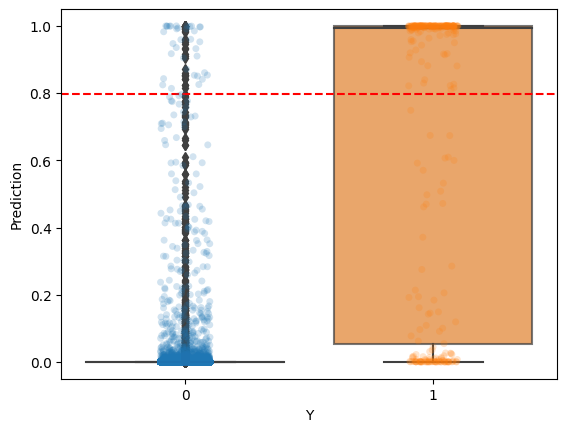

In [ ]:
import matplotlib as plt
import seaborn as sns

ax = sns.boxplot(x='Y', y='Prediction', data=dt_pred_cnn, boxprops=dict(alpha=0.7))
sns.stripplot(data=dt_pred_cnn, y='Prediction', x='Y', hue='Y',
              alpha=0.2, legend=False)
ax.axhline(y=best_threshold_cnn, color="red", linestyle="--", label=f'Best Threshold ({best_threshold_cnn:.2f})')

In [ ]:
dt_pred_cnn['YPrediction'] = np.where(dt_pred_cnn['Prediction'] >= best_threshold_cnn, 1, 0)
confusion_matrix(dt_pred_cnn['Y'], dt_pred_cnn['YPrediction'])

array([[96685,    35],
       [  112,   200]])